# Books recommendation system

Recommender systems are common in our daily lives, being used by companies like Amazon to suggest products to purchase and by streaming services to recommend movies or TV shows to watch. In this project  we will build a book recommendation system  to provide personalized book suggestions to our users.

After a brief introduction to recommendation systems, we will export the cleaned and explored data from our previous Jupyter notebook and begin building our model.

A recommendation system is a type of information filtering system that suggests the most relevant items to a particular user or customer. There are various types of recommendation systems, including collaborative filtering, content-based systems, and knowledge-based recommendation systems. These systems utilize different techniques to analyze user data and generate personalized recommendations based on factors such as user preferences, behavior, and past interactions.

Collaborative filtering: generates recommendations based on the interests of similar users. This method requires historical activity data for the users. For this project we will be using users' past book rating. Collaborative filtering algorithms can be user-based or item-based. User-based algorithms recommend items to a user based on the preferences of similar users, while item-based algorithms recommend items based on the past ratings of similar items by the user.
   * K-Nearest Neighbors (KNN) is one  of the basic  algorithms used in collaborative filtering algorithm. The way the algorithm work by computing the K-nearest neighbors of a given user or item based on their past rating and then using their ratings to predict the rating of an unrated item or to generate a list of recommended items. This approach could be simple and effective but has some limitation like scaling to large dataset. To address these challenges and improve recommendation other collaborative filtering algorithm have been developed, such as Singular Value Decomposition (SVD) base on matrix factorization.

   * Singular Value Decomposition (SVD) is a popular matrix factorization algorithm used in recommendation systems. It decomposes the user-item rating matrix into three matrices that capture the underlying structure of the data. SVD has proved to be effective in many recommendation applications and  was one of the main algorithms used by the winning team of the Netflix Prize competition. However, This algrothim also have it's limitaions. SVS suffer r form scalability problem because a facortizaing of large matrices need large amount of computational resources.

Content-based systems: suggest similar items based on a particular item metadata. The general idea behind these recommender systems is that if a person liked a particular item, they will also like an item that is similar to it. However, the only metadata we have about the books in our dataset is the title, author, and country, which is very limited. A good metadata for content-based systems would be the genres and  summary the the book, but unfortunately, we do not have that information. Additionally, this method is computationally expensive, which further limits its use. For these reasons, we will only use collaborative filtering in our book recommendation system.

We want to predict the rating given by a user to a book based on the book that he has already read and the books of user that have like the same books i.e similar users

# Loading the data previously cleaned

In [1]:
import pandas as pd
import numpy as np

In [2]:
path="./dataset/"
file="final_dataset.csv"
users_csv="cleaned_users.csv"
books_csv="cleaned_books.csv"
ratings_csv="cleaned_ratings.csv"

In [3]:
books = pd.read_csv(path+books_csv, sep=";",on_bad_lines='warn', encoding="latin-1")
books.bookId.max()

248251

## Choice of the algorithm

We use the library surprise to do the recommender system. It's a library specialised in this kind of machine learning. Sadly we could not use the age nor the location with this library as only 4 columns are allowed: user, item, rating and timestamp. The age and location could have been usefull to better determine the similitude between two users or items in the case of algorithm using similitude like KNN, .

We load the data into the data structure of the surprise library. For memory concern, we reduce the data to user having rated more than 5 books and book that have been rated more than 30 times to avoid memory arror.

In [4]:
# Loads Pandas dataframe
from surprise import Dataset
from surprise import Reader
#we reduce the size of the dataset by removing the user that rated less than 5 books and books
#that have been rated less than 30 times
df = pd.read_csv(path+file, sep=";",on_bad_lines='warn', encoding="latin-1")
df=df[df.userID.isin(df.userID.value_counts()[df.userID.value_counts()>5].index)][['userID','bookId','bookRating']]
df=df[df.bookId.isin(df.bookId.value_counts()[df.bookId.value_counts()>30].index)][['userID','bookId','bookRating']]
data = Dataset.load_from_df(df[['userID','bookId','bookRating']], Reader(line_format='user item rating', sep=";",rating_scale=(1, 10)))
len(df.bookId.unique())

806

In [5]:
##to see what is in the built in data of surprise
d=pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
d.head()

,user_id,item_id,rating,timestamp
0,99,97,8.0,None
1,99,102,10.0,None
2,99,103,3.0,None
3,114,119,10.0,None
4,114,115,9.0,None


We benchmark the different models by using a cross validation after having set the the seed of the RNG to have reproducible experiments. We use RMSE to measure the performance.

In [6]:
import random
import numpy as np

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [7]:
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise.model_selection import cross_validate
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(verbose =False), SVDpp(verbose =False), SlopeOne(), KNNBaseline(verbose =False), KNNBasic(verbose =False), KNNWithMeans(verbose =False), KNNWithZScore(verbose =False), BaselineOnly(verbose =False), CoClustering(verbose =False)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.592888,0.414601,0.070400
BaselineOnly,1.594112,0.106767,0.059600
SVDpp,1.604308,1.238800,0.269001
KNNBaseline,1.688640,2.035064,0.883998
CoClustering,1.709618,1.651073,0.035796
KNNWithMeans,1.755192,1.336251,0.644402
KNNWithZScore,1.760181,1.634571,0.762471
KNNBasic,1.778996,1.450997,0.646800
SlopeOne,1.862809,0.408987,0.186599


BaselineOnly and SVD give us the lowest rmse error,  although BaselineOnly also give us the best time, so it' is one of this two we should use. As KNNBseline can be configured by using similitude we also futher test it with both user_based and item_based configuration.
We will be using the `GridSearchCv` to find the best hyperparameters values for the selected models.

## Hyper tuning of BaseLineOnly

In [8]:
from surprise.model_selection import GridSearchCV
bsl_options = {"method": ["als"], "n_epochs": [10,15,20,25 ], "reg_u": [4,5,10,15,20], "reg_i": [5,10,15,20]}
param_grid={"bsl_options":bsl_options}
gs = GridSearchCV(BaselineOnly, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
best_param_bsl=gs.best_params["rmse"]
print(best_param_bsl)

1.5611580885598726
{'bsl_options': {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 10}}


## Hyper tuning of SVD

In [9]:
param_grid = {"n_epochs": [15,20,25,30],"lr_all": [0.004,0.008,0.01,0.02],"reg_all": [0,0.02,0.4,0.5, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
best_param_svd=gs.best_params["rmse"]
print(best_param_svd)

1.5705037306503074
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}


## Hyper tuning of KNNBaseLine 

In [10]:
""""bsl_options = {"method": ["als"], "n_epochs": [15,20,25 ], "reg_u": [2,5,8,10], "reg_i": [2,4,6]}
sim_options = {"name": ["cosine"],"user_based": [True,False]}
param_grid = {"bsl_options":bsl_options, "sim_options":sim_options, "k":[20,40,60]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])"""

'"bsl_options = {"method": ["als"], "n_epochs": [15,20,25 ], "reg_u": [2,5,8,10], "reg_i": [2,4,6]}\nsim_options = {"name": ["cosine"],"user_based": [True,False]}\nparam_grid = {"bsl_options":bsl_options, "sim_options":sim_options, "k":[20,40,60]}\ngs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)\ngs.fit(data)\n\nprint(gs.best_score["rmse"])\nprint(gs.best_params["rmse"])'

# Training of the model

The benchmark and the tunning of the model show that the best model is the `BaseLineOnly` with the Alternating Least Squares procedure configured with `25` iterations, `reg_u=4` and `reg_i=10`.

In [11]:
from surprise.model_selection import train_test_split
from surprise import accuracy
bsl_options= best_param_bsl["bsl_options"]
trainset_bsl, testset_bsl = train_test_split(data, test_size=0.25)
#trainset_bsl = data.build_full_trainset()
algo_bsl = BaselineOnly(bsl_options=bsl_options,verbose =False)
algo_bsl.fit(trainset_bsl)

In [12]:
trainset_svd, testset_svd = train_test_split(data, test_size=0.25)
#trainset_svd = data.build_full_trainset()
algo_svd=SVD(n_epochs= best_param_svd.get("n_epochs"), lr_all= best_param_svd.get("lr_all")
             , reg_all= best_param_svd.get("reg_all"))
algo_svd.fit(trainset_svd)

To get the 5 best recommendation for each user we could use the function `get_top_n` provided by surprise QA section of documentation:

In [13]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [14]:
def get_top_n_by_algo(algo,trainset,k):
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)
    return predictions,get_top_n(predictions, n=k)

In [15]:
prediction_bsl,top_n_bsl = get_top_n_by_algo(algo_bsl,trainset_bsl,5)

In [16]:
prediction_svd,top_n_svd = get_top_n_by_algo(algo_svd,trainset_svd,5)

In [17]:
def count_occ(reco,i):
    if i in reco:reco[i]=reco.get(i)+1
    else: reco[i]=1

def count_books_recommended(rcd):
    reco={}
    [ [count_occ(reco,title[0]) for title in v]  for k,v in rcd.items()]
    return reco

In [18]:
recommended_books_bsl=count_books_recommended(top_n_bsl)

In [19]:
recommended_books_svd=count_books_recommended(top_n_svd)

In [20]:
get_book_by_id=lambda id_b:books.loc[books.bookId==id_b]["bookTitle"].iloc[0]

In [21]:
def get_recommendation_by_id(id_u,top_n):
    print("The recommendation for user",id_u, "are:\n")
    [print(get_book_by_id(iid),"with a rating of",r,"\n") for (iid, r) in top_n[id_u]]

In [22]:
def get_list_book_recommended(recommended_books):
    print(" book title |","nb recommended")
    [ print(get_book_by_id(k),v) for k,v in recommended_books.items()]

In [23]:
print("The baseline model has recommended a total of",len(recommended_books_bsl), "distinct books")
print("The SVD model has recommended a total of",len(recommended_books_svd), "distinct books")

The baseline model has recommended a total of 20 distinct books
The SVD model has recommended a total of 38 distinct books


In [24]:
print("books recommended with baseline")
get_list_book_recommended(recommended_books_bsl)

books recommended with baseline
 book title | nb recommended
The Return of the King (The Lord of the Rings, Part 3) 7789
The Two Towers (The Lord of the Rings, Part 2) 7808
Harry Potter and the Goblet of Fire (Book 4) 7718
Ender's Game (Ender Wiggins Saga (Paperback)) 7818
The Two Towers (The Lord of the Rings, Part 2) 7871
The Little Prince 354
To Kill a Mockingbird 43
Harry Potter and the Prisoner of Azkaban (Book 3) 53
LONESOME DOVE 41
The Neverending Story 36
1984 27
The Hobbit : The Enchanting Prelude to The Lord of the Rings 31
Girl with a Pearl Earring 1
The Poisonwood Bible: A Novel 1
Roses Are Red 1
Harry Potter and the Order of the Phoenix (Book 5) 29
Dune (Remembering Tomorrow) 12
Siddhartha 6
Bridge to Terabithia 5
Anne of Green Gables (Anne of Green Gables Novels (Paperback)) 1


In [25]:
print("books recommended with svd")
get_list_book_recommended(recommended_books_svd)

books recommended with svd
 book title | nb recommended
The Two Towers (The Lord of the Rings, Part 2) 7865
The Return of the King (The Lord of the Rings, Part 3) 7832
The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure 7849
Griffin & Sabine: An Extraordinary Correspondence 4428
The Secret Garden 1873
Dune (Remembering Tomorrow) 2177
The Two Towers (The Lord of the Rings, Part 2) 3640
Interpreter of Maladies 2302
Where the Red Fern Grows 227
The Little Prince 221
The Return of the King (The Lord of The Rings, Part 3) 237
Pride and Prejudice 1
LONESOME DOVE 40
The Fellowship of the Ring (The Lord of the Rings, Part 1) 301
84 Charing Cross Road 449
The Hobbit: or There and Back Again 12
A Fine Balance 1
Charlotte's Web (Trophy Newbery) 30
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) 6
The Fellowship of the Ring (The Lord of the Rings, Part 1) 25
Ender's Game (Ender Wiggins Saga (Paperback)) 2
To Kill a Mockingbird 6
The Curious Incident of

Example of recommendation for the user 229331:

In [26]:
get_recommendation_by_id(229331,top_n_svd)

The recommendation for user 229331 are:

The Two Towers (The Lord of the Rings, Part 2) with a rating of 8.946971523007504 

The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure with a rating of 8.912677442788986 

The Return of the King (The Lord of the Rings, Part 3) with a rating of 8.884388857160687 

The Two Towers (The Lord of the Rings, Part 2) with a rating of 8.799335788212733 

Griffin & Sabine: An Extraordinary Correspondence with a rating of 8.795541721928933 



We observe that on all the 806 books the svd model has recommended 43 books, 20 more that the baseline model so it has more versality than the baseline model. Nonetheless, this show one weakness in this kind of algorithm: it's always a minority of books that are recommended and books with few ratings can't be recommended hence all users are given more or less the same books. The only downside of SVD is its computing time that is longer

Finally, we measure the accuracy of the ratings we have get

In [27]:
def get_metrics(predict):
    accuracy.rmse(predict)
    accuracy.mse(predict)
    accuracy.mae(predict)

In [28]:
print("metrics for baseline")
get_metrics(prediction_bsl)

metrics for baseline
RMSE: 0.6882
MSE: 0.4737
MAE:  0.5333


In [29]:
print("metrics for SVD")
get_metrics(prediction_svd)

metrics for SVD
RMSE: 0.6634
MSE: 0.4401
MAE:  0.5189


For book recommender system an RMSE of around 1.0 or lower might be considered good. We could assume  that the two proposed  recommender system are efficient. The SVD is a little bit more efficient but it is also more interesting because more different books are recommended. So this this algorithm that we choose to use although it's 5 times slower than baseline so that choice can be debatable: if we need a fast answer by the recommender system, baseline wil be a better choice.
We are going  also to evaluate  the recall and precision at k which are also  commonly used to metrics for recommender systems. especially when the task involve  top-k recommended items. The FAQ of the surprise library give this implementation:

In [30]:
from collections import defaultdict
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=5, threshold=7):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

We are now choosing wich book ratings we should recommend and how many.

In [31]:
def get_recall_precision_F1(algo,k,t):
    kf = KFold(n_splits=k)
    mean_prec=0.
    mean_recall=0.
    i=0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=t)
        # Precision and recall can then be averaged over all users
        p=sum(prec for prec in precisions.values()) / len(precisions)
        r=sum(rec for rec in recalls.values()) / len(recalls)
        mean_prec+=p
        mean_recall+=r
        i+=1
    mean_prec, mean_recall=mean_prec/k,mean_recall/k
    return mean_prec, mean_recall,2*mean_recall*mean_prec/(mean_recall+mean_prec)

In [32]:
def get_f1_data_k(algo,t):
    k_array,prec_array,recall_array,f1_array=[],[],[],[]
    for i in np.arange(2,16):
        k_array.append(i)
        result=get_recall_precision_F1(algo,i,t)
        prec_array.append(result[0])
        recall_array.append(result[1])
        f1_array.append(result[2])
    return k_array,prec_array,recall_array,f1_array

Text(0.5, 1.0, 'F1_score of the SVD algorithm by Number of recommendation')

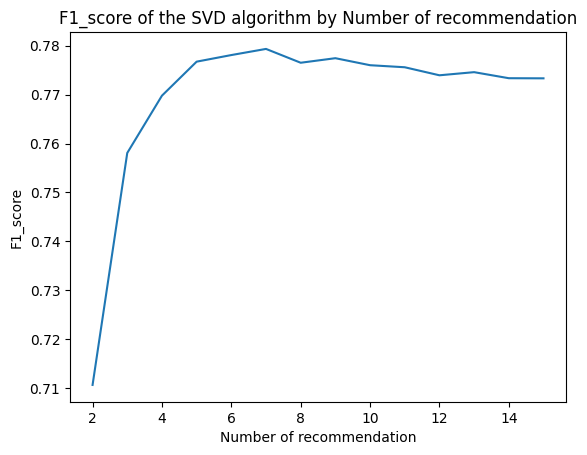

In [33]:
import matplotlib.pyplot as plt
k_array,prec_array,recall_array,f1_array=get_f1_data_k(algo_svd,7)
plt.plot(k_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Number of recommendation")
plt.title("F1_score of the SVD algorithm by Number of recommendation")

We observe that the F1_score is maximal with 7 books recommended and that it doesn' have a great variation as it's approximatively always 80% after 5 books recommended, so this parameter is not very important in our case. 7 is still a good value as we don't want to recommend too many books as a user usually consider only the first books recommended.

In [34]:
def get_f1_data_t(algo,k):
    r_array,prec_array,recall_array,f1_array=[],[],[],[]
    for r in np.arange(2,11):
        r_array.append(r)
        result=get_recall_precision_F1(algo,k,r)
        prec_array.append(result[0])
        recall_array.append(result[1])
        f1_array.append(result[2])
    return r_array,prec_array,recall_array,f1_array

Text(0.5, 1.0, 'F1_score of the SVD algorithm by rating threshold')

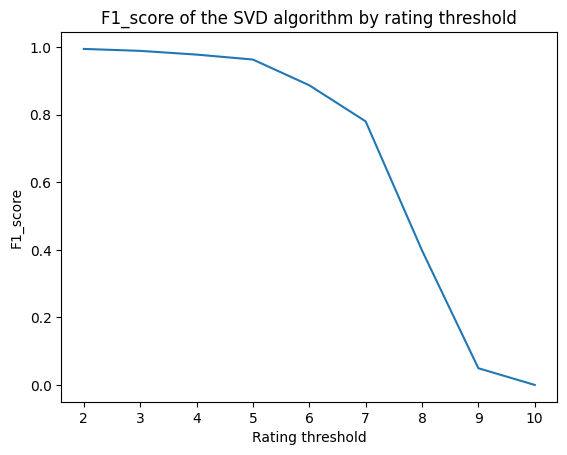

In [35]:
import matplotlib.pyplot as plt
r_array,prec_array,recall_array,f1_array=get_f1_data_t(algo_svd,7)
get_f1_data_t
plt.plot(r_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Rating threshold")
plt.title("F1_score of the SVD algorithm by rating threshold")

We observe that the F1 score decrease with the increse of rating threshold wich is logical as more we are strict with the rating of the book to recommend more it'is difficult to respect the condition. The curve drop significantly after a threshold of 7. As book ratings of 5 and 6 are a little low to be recommended, We should use 7 as threshold even if a F1_score of 80% is a little low.

We get a precision of 80%, a recall of 82% and a F1 score of 80% which is average and coherent with the results obtained with the RMSE. This model is acceptable for our need but a better model can/should be found and it will be inacceptable in many field such as health.

This machine learning problem has shown us two limits of recommender system only done with python: limitation of memory and time of computation. 
It partly explain why the graph database are so often used in the domain of recommendation. With this kind of base it's much more easy to find similar item or user as the algorithm just need to go from node to node based on relationship and we don't store useless informationin the memory, only usefull one. 

Reference:

"Hands on recommendation systems with Python" by Rounak Banik 

"Graph-Powered Machine Learning" by Alessandro Negro

https://realpython.com/build-recommendation-engine-collaborative-filtering/

https://surprise.readthedocs.io/en/stable/FAQ.html